In [ ]:
!pip install timm
!pip install lightning
!pip install astropy
import torch
import torch.nn as nn
import timm
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm


import sys
sys.path.append('/content/')

from dataloader_fits_cr import SunImageDataset

from lightning.fabric import Fabric

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

import scipy.stats as stats

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

zip_path = '/content/drive/MyDrive/Dataset/aia_synoptic_copy_1.zip'
extract_path = '/content/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
# Hyper-parameters
input_size = 224*224
hidden_size = 166
# hidden_size = 1024
num_epochs = 10
batch_size = 2
learning_rate = 0.001
dropout = 0.5
lstm_layers = 2

k_folds = 5

In [ ]:
import random
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

set_seed(42)

In [ ]:
dataset = SunImageDataset(csv_file="/content/dataset_full_with_cr_6days.csv", offset=0)

total_size = len(dataset)
fold_size = total_size // k_folds
indices = list(range(total_size))

k_fold_1_indices = indices[:fold_size]
k_fold_2_indices = indices[fold_size:2*fold_size]
k_fold_3_indices = indices[2*fold_size:3*fold_size]
k_fold_4_indices = indices[3*fold_size:4*fold_size]
k_fold_5_indices = indices[4*fold_size:]

print(len(k_fold_1_indices))
print(len(k_fold_2_indices))
print(len(k_fold_3_indices))
print(len(k_fold_4_indices))
print(len(k_fold_5_indices))

dataloaders = [k_fold_1_indices, k_fold_2_indices, k_fold_3_indices, k_fold_4_indices, k_fold_5_indices]

# Get date list
kp_dates = pd.read_csv("/content/matched_kp_dates_full_with_cr_6days.csv")
kp_dates_list = kp_dates["date"].tolist()

1097
1097
1097
1097
1099


In [ ]:
# Get active indices
dataset_csv_file = pd.read_csv("/content/dataset_full_with_cr_6days.csv")
active_indices = []

for i in dataset_csv_file.index:
    if dataset_csv_file['Kp'][i] >= 3.667:
        active_indices.append(i)

active_dataloaders = []
for dataloader in dataloaders:
    active_dataloaders.append(list(set(dataloader) & set(active_indices)))

for dataloader in active_dataloaders:
    print(len(dataloader))

298
256
380
441
305


In [ ]:

class GmiSwinTransformer(nn.Module):
    def __init__(self, hidden_size: int):
        super(GmiSwinTransformer, self).__init__()

        # Batch normalization for 3 channels
        self.bn = nn.BatchNorm2d(3)

        # Initialize Swin Transformer
        self.pretrained_model = timm.create_model(
            'swin_base_patch4_window7_224',
            pretrained=True,
            num_classes=hidden_size
        )

        self.lstm = nn.LSTM(hidden_size, hidden_size * 2, lstm_layers, batch_first=True)

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.LeakyReLU(),
            nn.Dropout(p=dropout),
            nn.Linear((hidden_size*2) + 2, hidden_size),
            nn.Dropout(p=dropout),  # Added dropout probability
            nn.LeakyReLU(),
            nn.Linear(hidden_size, 1),

        )

    def forward(self, images, kp) -> torch.Tensor:
        """
        Batch should be in format:
        {
            'images': torch.FloatTensor((10, 1, 224, 224))
        }
        """

        batch_size = images.shape[0]

        images = images.reshape(-1, 1, 224, 224)
        images = torch.cat([images, images, images], dim=1)
        normalized_images = self.bn(images)
        features = self.pretrained_model(normalized_images)
        image_features = features.view(batch_size, 10, -1)
        # hidden_states = torch.zeros(lstm_layers, image_features.size(0), hidden_size * 2)
        # cell_states = torch.zeros(lstm_layers, image_features.size(0), hidden_size * 2)
        # image_features, _ = self.lstm(image_features, (hidden_states, cell_states))
        image_features, _ = self.lstm(image_features)
        image_features = image_features[:, -1, :]
        kp = kp.reshape(batch_size, 1)
        kp = kp.repeat(1, 2)
        image_features = torch.cat((image_features, kp), dim=1)
        output = self.fc(image_features)
        return output

# Initialize model
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = GmiSwinTransformer(hidden_size=hidden_size).to(device)
model = GmiSwinTransformer(hidden_size=hidden_size)

# print(torchsummary.summary(model, (10, 1, 224, 224)))

# Loss and optimizer
criterion = nn.MSELoss()

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

In [ ]:
torch.cuda.empty_cache()

In [ ]:
def calculate_rates(all_outputs, all_labels):
    storm_labels = []
    for output in all_labels:
        if output < 3.667:
            storm_labels.append(0)
        else:
            storm_labels.append(1)
    storm_outputs = []
    for output in all_outputs:
        if output < 3.667:
            storm_outputs.append(0)
        else:
            storm_outputs.append(1)

    # Calculate true positive, true negative, false positive, false negative
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for i in range(len(storm_labels)):
        if storm_labels[i] == 1 and storm_outputs[i] == 1:
            tp += 1
        elif storm_labels[i] == 0 and storm_outputs[i] == 0:
            tn += 1
        elif storm_labels[i] == 0 and storm_outputs[i] == 1:
            fp += 1
        elif storm_labels[i] == 1 and storm_outputs[i] == 0:
            fn += 1

    return tp, tn, fp, fn


def true_skill_score(tp, tn, fp, fn):

    # Calculate true skill score
    tss = (tp / (tp + fp)) - (fp / (fp + tn)) if ((tp > 0 and tn > 0) or fp > 0) else 0
    return tss

def calculate_metrics(tp, tn, fp, fn):
    # Calculate accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

    # Calculate precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0

    # Calculate recall
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    # Calculate F1 score
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return accuracy, precision, recall, f1





In [ ]:
def train_model(fabric):
  print(fabric.device)
  total_avg_test_loss = 0
  total_rmse = 0
  total_mse = 0
  total_mae = 0
  total_r2 = 0
  total_r = 0
  total_tts = 0
  total_accuracy = 0
  total_precision = 0
  total_recall = 0
  total_f1 = 0

  active_total_avg_test_loss = 0
  active_total_rmse = 0
  active_total_mse = 0
  active_total_mae = 0
  active_total_r2 = 0
  active_total_r = 0


  for i in range(k_folds):
      print(f'FOLD {i + 1}')
      print('--------------------------------')
      test_indices = dataloaders[i]
      active_test_indices = active_dataloaders[i]
      train_indices = []
      for j in range(k_folds):
          if j != i:
              train_indices += dataloaders[j]

      trainloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, train_indices), batch_size=batch_size, shuffle=True, num_workers=20, prefetch_factor=6, pin_memory=True, worker_init_fn=lambda _: np.random.seed(42))
      testloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, test_indices), batch_size=batch_size, shuffle=False, num_workers=20, prefetch_factor=6, pin_memory=True)
      active_testloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, active_test_indices), batch_size=batch_size, shuffle=False, num_workers=20, prefetch_factor=6, pin_memory=True)
      trainloader = fabric.setup_dataloaders(trainloader)
      testloader = fabric.setup_dataloaders(testloader)
      active_testloader = fabric.setup_dataloaders(active_testloader)


      # Reinitialize model
      model = GmiSwinTransformer(hidden_size=hidden_size)
      optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
      model, optimizer = fabric.setup(model, optimizer)
      model.train()

      # Training the model
      n_total_steps = len(trainloader)
      avg_train_loss_over_epochs = []
      avg_val_loss_over_epochs = []

      for epoch in range(num_epochs):
          train_losses = []
          val_losses = []

          # Training loop
          model.train()
          for i, (images, labels, p_Kp) in tqdm(enumerate(trainloader), desc=f"Training Progress: Epoch: {epoch + 1}", total=len(trainloader)):
              # Move images and labels to device
              images = images.float()
              labels = labels.float()
              p_Kp = p_Kp.float()

              # Forward pass with autograd
              outputs = model(images, p_Kp).squeeze(1)
              loss = criterion(outputs, labels)
              # tqdm.write(f"Epoch: {epoch+1}, Index: {i}, Loss: {loss.item():.4f}")

              # Backward pass and optimization
              optimizer.zero_grad()
              fabric.backward(loss)
              optimizer.step()
              # Store the loss
              train_losses.append(loss.item())

          # Store the average training loss for this epoch
          avg_train_loss_over_epochs.append(sum(train_losses) / len(train_losses))
          print("Average Training Loss: ", sum(train_losses) / len(train_losses))

          # Validation loop
          model.eval()
          with torch.no_grad():
              for images, labels, p_Kp in tqdm(testloader, desc=f"Validation Progress: Epoch: {epoch + 1}", total=len(testloader)):
                  images = images.float()
                  p_Kp = p_Kp.float()
                  # images = images.permute(1, 0, 2, 3, 4)
                  labels = labels.float()
                  outputs = model(images, p_Kp).squeeze(1)
                  loss = criterion(outputs, labels)
                  # print("Validation Loss: ", loss.item())
                  val_losses.append(loss.item())

          # Store the average validation loss for this epoch
          avg_val_loss_over_epochs.append(sum(val_losses) / len(val_losses))
          print("Average Validation Loss: ", sum(val_losses) / len(val_losses))

      # Plot loss over epochs
      plt.figure()
      plt.plot(range(1, num_epochs + 1), avg_train_loss_over_epochs, label='Average Training Loss', marker='o')
      plt.plot(range(1, num_epochs + 1), avg_val_loss_over_epochs, label='Average Validation Loss', marker='o')
      plt.xticks(range(1, num_epochs + 1))  # Ensure x-axis includes all epoch numbers
      plt.xlabel('Epoch')
      plt.ylabel('Average Loss')
      plt.legend()
      plt.title('Training and Validation Loss Over Epochs')
      plt.show()

      test_losses = []
      all_labels = []
      all_outputs = []

      model.eval()

      print('--------------------------------')
      print('Test for Full set')
      print('--------------------------------')

  # Test for Full set
      with torch.no_grad():
          for images, labels, p_Kp in tqdm(testloader, desc="Testing Progress"):
              images = images.float()
              # images = images.permute(1, 0, 2, 3, 4)
              labels = labels.float()
              p_Kp = p_Kp.float()
              # print("Label: ", labels)
              outputs = model(images, p_Kp).squeeze(1)
              # print("Output: ", outputs)
              loss = criterion(outputs, labels)
              test_losses.append(loss.item())
              all_labels.extend(labels.cpu().numpy())
              all_outputs.extend(outputs.cpu().numpy())

      avg_test_loss = sum(test_losses) / len(test_losses)
      rmse = math.sqrt(avg_test_loss)
      mse = mean_squared_error(all_labels, all_outputs)
      mae = mean_absolute_error(all_labels, all_outputs)
      r2 = r2_score(all_labels, all_outputs)
      r, _ = stats.pearsonr(all_labels, all_outputs)
      tp, tn, fp, fn = calculate_rates(all_outputs, all_labels)
      accuracy, precision, recall, f1 = calculate_metrics(tp, tn, fp, fn)
      tts = true_skill_score(tp, tn, fp, fn)



      # Accumulate metrics for averaging across folds
      total_avg_test_loss += avg_test_loss
      total_rmse += rmse
      total_mse += mse
      total_mae += mae
      total_r2 += r2
      total_r += r
      total_tts += tts
      total_accuracy += accuracy
      total_precision += precision
      total_recall += recall
      total_f1 += f1


      print(f'Average test loss: {avg_test_loss:.4f}')
      print(f'RMSE: {rmse:.4f}')
      print(f'MSE: {mse:.4f}')
      print(f'MAE: {mae:.4f}')
      print(f'R²: {r2:.4f}')
      print(f'R: {r:.4f}')
      print(f'True Skill Score: {tts:.4f}')
      print(f'Accuracy: {accuracy:.4f}')
      print(f'Precision: {precision:.4f}')
      print(f'Recall: {recall:.4f}')
      print(f'F1 Score: {f1:.4f}')

      test_dates = list(kp_dates_list[i] for i in test_indices)
      # Convert to pandas Series for easy rolling average calculation
      labels_series = pd.Series(all_labels)
      outputs_series = pd.Series(all_outputs)

      # Calculate rolling averages with window size of 5
      window_size = 2
      labels_rolling = labels_series.rolling(window=window_size, center=True).mean()
      outputs_rolling = outputs_series.rolling(window=window_size, center=True).mean()

      # Create a better-looking plot
      plt.figure(figsize=(50, 6), facecolor='#f8f9fa')
      plt.plot([0, len(test_dates)], [3.667, 3.667], 'r--', alpha=0.6, label='Kp = 4-')
      # Plot original data with thin lines
      plt.plot(all_labels, '-', color='#1f77b4', linewidth=1, alpha=0.6, label='Actual Labels')
      plt.plot(all_outputs, '--', color='#ff7f0e', linewidth=1, alpha=0.6, label='Predicted Labels')

      # Plot smoothed data with thicker lines
      plt.plot(labels_rolling, '-', color='#2c5282', linewidth=2.5, label='Actual Labels (Smoothed)')
      plt.plot(outputs_rolling, '--', color='#c05621', linewidth=2.5, label='Predicted Labels (Smoothed)')

      # Format x-axis with dates
      test_dates_sliced = test_dates[0:len(all_labels):20]
      plt.xticks(range(0, len(test_dates), 20), test_dates_sliced, rotation=30, ha='right')

      # Better grid styling
      plt.grid(True, linestyle='--', alpha=0.7)

      # Improve labels and title
      plt.xlabel('Date', fontsize=12)
      plt.ylabel('KP Index', fontsize=12)
      plt.title('Comparison of Actual vs Predicted KP Index Values', fontsize=14)

      # Better legend
      plt.legend(loc='best', frameon=True, fontsize=12)

      # Adjust layout for better spacing
      plt.tight_layout()

      plt.show()
      print(all_outputs)

      print('--------------------------------')
      print('Test for Active Periods')
      print('--------------------------------')

      test_losses = []
      all_labels = []
      all_outputs = []

  # Test for active periods
      with torch.no_grad():
          for images, labels, p_Kp in tqdm(active_testloader, desc="Testing Progress"):
              images = images.float()
              labels = labels.float()
              p_Kp = p_Kp.float()
              outputs = model(images, p_Kp).squeeze(1)
              loss = criterion(outputs, labels)
              test_losses.append(loss.item())
              all_labels.extend(labels.cpu().numpy())
              all_outputs.extend(outputs.cpu().numpy())

      avg_test_loss = sum(test_losses) / len(test_losses)
      rmse = math.sqrt(avg_test_loss)
      mse = mean_squared_error(all_labels, all_outputs)
      mae = mean_absolute_error(all_labels, all_outputs)
      r2 = r2_score(all_labels, all_outputs)
      r, _ = stats.pearsonr(all_labels, all_outputs)
      tp, tn, fp, fn = calculate_rates(all_outputs, all_labels)
      accuracy, precision, recall, f1 = calculate_metrics(tp, tn, fp, fn)
      tts = true_skill_score(tp, tn, fp, fn)



      # Accumulate metrics for averaging across folds
      active_total_avg_test_loss += avg_test_loss
      active_total_rmse += rmse
      active_total_mse += mse
      active_total_mae += mae
      active_total_r2 += r2
      active_total_r += r




      print(f'Average test loss: {avg_test_loss:.4f}')
      print(f'RMSE: {rmse:.4f}')
      print(f'MSE: {mse:.4f}')
      print(f'MAE: {mae:.4f}')
      print(f'R²: {r2:.4f}')
      print(f'R: {r:.4f}')
      print(f'True Skill Score: {tts:.4f}')
      print(f'Accuracy: {accuracy:.4f}')
      print(f'Precision: {precision:.4f}')
      print(f'Recall: {recall:.4f}')
      print(f'F1 Score: {f1:.4f}')
      # Convert to pandas Series for easy rolling average calculation
      labels_series = pd.Series(all_labels)
      outputs_series = pd.Series(all_outputs)

      # Calculate rolling averages with a window size of 5
      window_size = 2
      labels_rolling = labels_series.rolling(window=window_size, center=True).mean()
      outputs_rolling = outputs_series.rolling(window=window_size, center=True).mean()

      # Create a better-looking plot
      plt.figure(figsize=(50, 6), facecolor='#f8f9fa')

      plt.plot([0, len(all_labels)], [3.667, 3.667], 'r--', alpha=0.6, label='Kp = 4-')

      # Plot original data with thin lines
      plt.plot(all_labels, '-', color='#1f77b4', linewidth=1, alpha=0.6, label='Actual Labels')
      plt.plot(all_outputs, '--', color='#ff7f0e', linewidth=1, alpha=0.6, label='Predicted Labels')

      # Plot smoothed data with thicker lines
      plt.plot(labels_rolling, '-', color='#2c5282', linewidth=2.5, label='Actual Labels (Smoothed)')
      plt.plot(outputs_rolling, '--', color='#c05621', linewidth=2.5, label='Predicted Labels (Smoothed)')

      # Better grid styling
      plt.grid(True, linestyle='--', alpha=0.7)

      # Improve labels and title
      plt.xlabel('Sample Index', fontsize=12)
      plt.ylabel('KP Index', fontsize=12)
      plt.title('Comparison of Actual vs Predicted KP Index Values', fontsize=14)

      # Better legend
      plt.legend(loc='best', frameon=True, fontsize=12)

      # Adjust layout for better spacing
      plt.tight_layout()

      plt.show()
      print(all_outputs)


  print('--------------------------------')
  print('Metrics for Full Set')
  print('--------------------------------')

  # Average metrics across all folds
  total_avg_test_loss /= k_folds
  total_rmse /= k_folds
  total_mse /= k_folds
  total_mae /= k_folds
  total_r2 /= k_folds
  total_r /= k_folds
  total_tts /= k_folds
  total_accuracy /= k_folds
  total_precision /= k_folds
  total_recall /= k_folds
  total_f1 /= k_folds

  print(f'Average test loss across all folds: {total_avg_test_loss:.4f}')
  print(f'Average RMSE across all folds: {total_rmse:.4f}')
  print(f'Average MSE across all folds: {total_mse:.4f}')
  print(f'Average MAE across all folds: {total_mae:.4f}')
  print(f'Average R² across all folds: {total_r2:.4f}')
  print(f'Average R across all folds: {total_r:.4f}')
  print(f'Average active R across all folds: {active_total_r:.4f}')
  print(f'Average True Skill Score across all folds: {total_tts:.4f}')
  print(f'Average Accuracy across all folds: {total_accuracy:.4f}')
  print(f'Average Precision across all folds: {total_precision:.4f}')
  print(f'Average Recall across all folds: {total_recall:.4f}')
  print(f'Average F1 Score across all folds: {total_f1:.4f}')

  print('--------------------------------')
  print('Metrics for Active Periods')
  print('--------------------------------')
  # Average metrics across all folds
  active_total_avg_test_loss /= k_folds
  active_total_rmse /= k_folds
  active_total_mse /= k_folds
  active_total_mae /= k_folds
  active_total_r2 /= k_folds
  active_total_r /= k_folds

  print(f'Average active test loss across all folds: {active_total_avg_test_loss:.4f}')
  print(f'Average active RMSE across all folds: {active_total_rmse:.4f}')
  print(f'Average active MSE across all folds: {active_total_mse:.4f}')
  print(f'Average active MAE across all folds: {active_total_mae:.4f}')
  print(f'Average active R² across all folds: {active_total_r2:.4f}')
  print(f'Average active R across all folds: {active_total_r:.4f}')




INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)


cuda:0
FOLD 1
--------------------------------


Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.3980836249286774


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7987796644911098


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.7980048618769455


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.9872766894696743


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.5030912776942136


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.9184730605470304


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.0673912854116714


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.9615939166954548


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.7832021989047253


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.512647372258035


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.6174830691293327


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.22223547141407


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.5166208015354442


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.177007102220169


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.4444834594676459


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.1103197250908363


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.397194966933611


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.188842078048811


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.36257329829699353


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.308343239346789


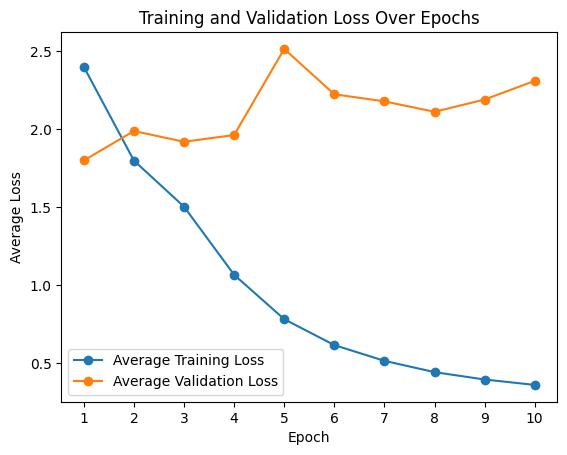

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 2.3083
RMSE: 1.5193
MSE: 2.3101
MAE: 1.2026
R²: -0.3093
R: 0.0855
True Skill Score: 0.1200
Accuracy: 0.6509
Precision: 0.3466
Recall: 0.3221
F1 Score: 0.3339


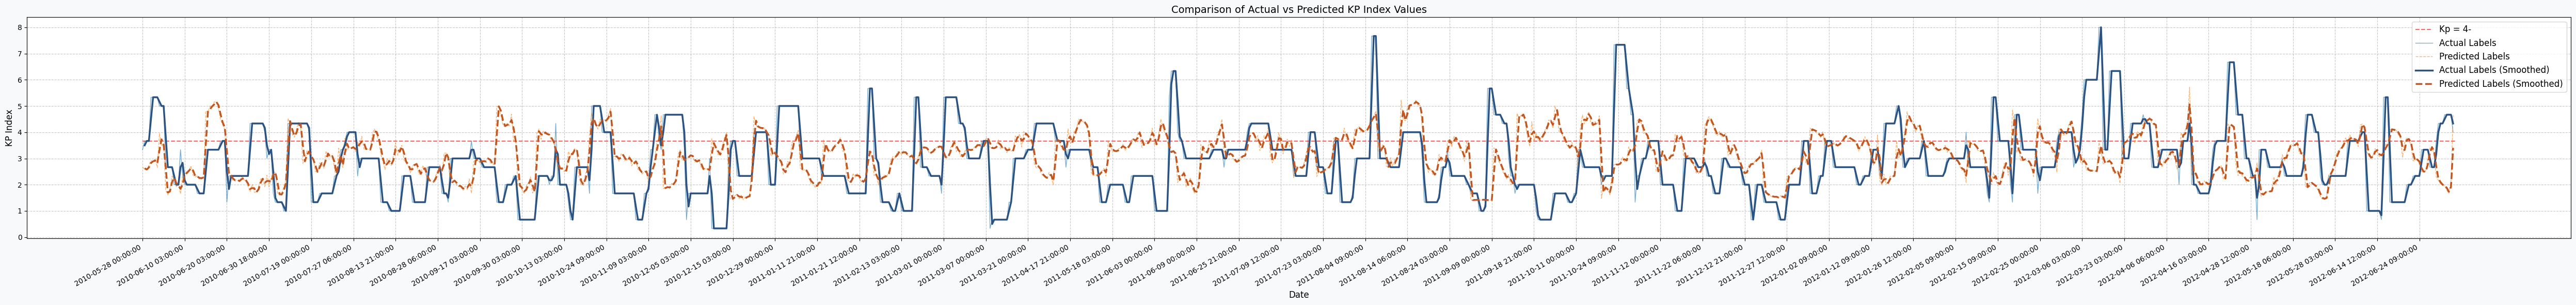

[np.float32(2.671875), np.float32(2.578125), np.float32(2.578125), np.float32(2.734375), np.float32(2.921875), np.float32(2.859375), np.float32(2.984375), np.float32(2.65625), np.float32(3.953125), np.float32(3.5), np.float32(3.53125), np.float32(1.7890625), np.float32(1.609375), np.float32(1.875), np.float32(2.328125), np.float32(2.203125), np.float32(1.921875), np.float32(2.03125), np.float32(1.6484375), np.float32(2.375), np.float32(2.359375), np.float32(2.53125), np.float32(2.53125), np.float32(2.71875), np.float32(2.359375), np.float32(2.296875), np.float32(2.328125), np.float32(2.1875), np.float32(2.296875), np.float32(2.265625), np.float32(4.8125), np.float32(4.75), np.float32(5.0), np.float32(4.96875), np.float32(5.15625), np.float32(5.15625), np.float32(4.90625), np.float32(4.46875), np.float32(4.28125), np.float32(4.09375), np.float32(2.4375), np.float32(2.390625), np.float32(2.3125), np.float32(2.140625), np.float32(2.1875), np.float32(2.171875), np.float32(2.109375), np.flo

Testing Progress:   0%|          | 0/149 [00:00<?, ?it/s]

Average test loss: 3.6049
RMSE: 1.8987
MSE: 3.6049
MAE: 1.5067
R²: -3.1438
R: -0.0675
True Skill Score: 0.0000
Accuracy: 0.3221
Precision: 1.0000
Recall: 0.3221
F1 Score: 0.4873


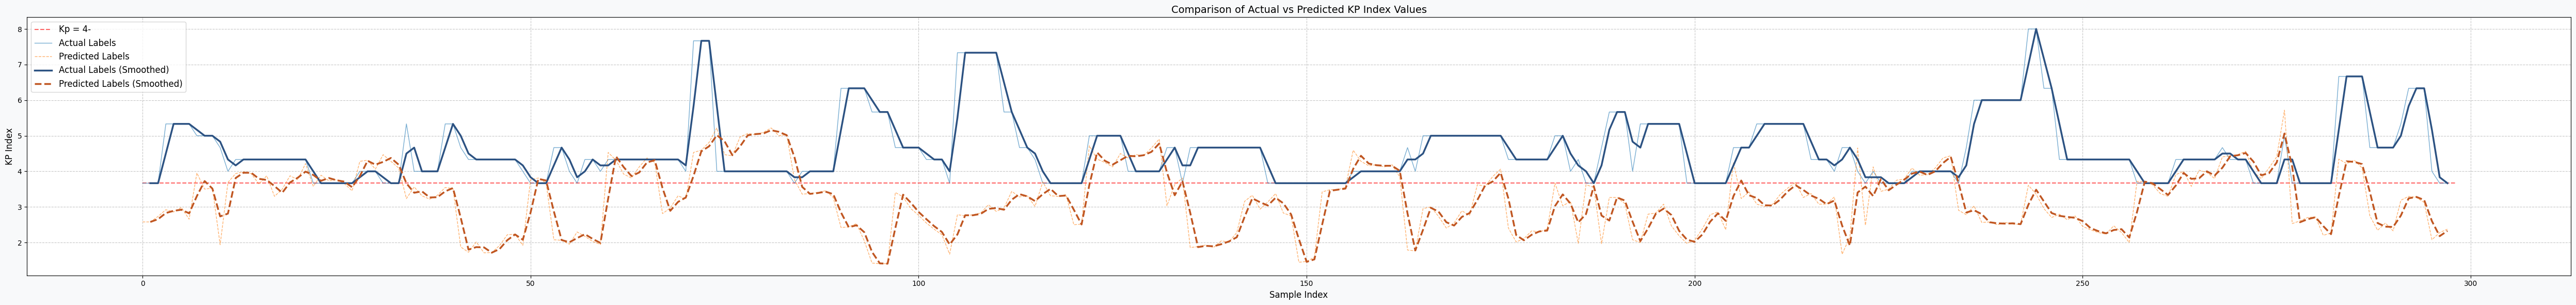

[np.float32(2.578125), np.float32(2.578125), np.float32(2.734375), np.float32(2.921875), np.float32(2.859375), np.float32(2.984375), np.float32(2.65625), np.float32(3.953125), np.float32(3.5), np.float32(3.53125), np.float32(1.9375), np.float32(3.6875), np.float32(3.9375), np.float32(3.984375), np.float32(3.9375), np.float32(3.640625), np.float32(3.875), np.float32(3.296875), np.float32(3.5), np.float32(3.875), np.float32(3.765625), np.float32(4.21875), np.float32(3.578125), np.float32(3.890625), np.float32(3.734375), np.float32(3.765625), np.float32(3.65625), np.float32(3.453125), np.float32(4.28125), np.float32(4.3125), np.float32(4.0625), np.float32(4.46875), np.float32(4.28125), np.float32(4.09375), np.float32(3.234375), np.float32(3.5625), np.float32(3.3125), np.float32(3.21875), np.float32(3.328125), np.float32(3.546875), np.float32(3.515625), np.float32(1.875), np.float32(1.7265625), np.float32(2.015625), np.float32(1.7109375), np.float32(1.71875), np.float32(1.9140625), np.floa

Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.3237790971516823


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.461861310934209


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.7866180679916304


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.1087045486140172


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.5070352273895258


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.097403986703834


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.1423249931974329


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.751914811473398


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.8485906974928282


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.25832680106979


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.6819743991825478


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  3.488922264167398


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.5668962992843509


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.3357441071899214


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.4760114674076427


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.817621806041229


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.4160877692784317


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.8139689204661353


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.3562460204914824


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.811094935508428


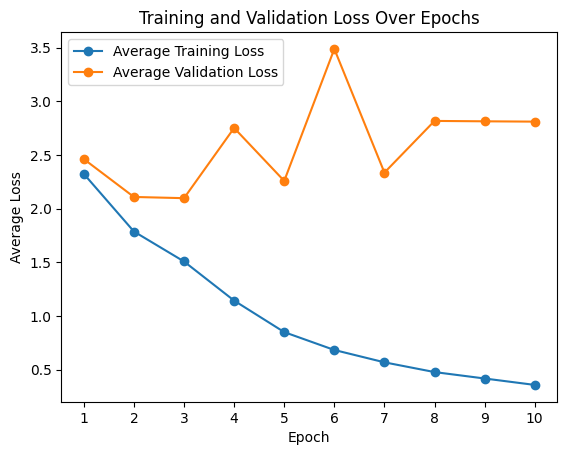

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 2.8111
RMSE: 1.6766
MSE: 2.8130
MAE: 1.3705
R²: -0.4184
R: -0.0768
True Skill Score: -0.0547
Accuracy: 0.6272
Precision: 0.1772
Recall: 0.1641
F1 Score: 0.1704


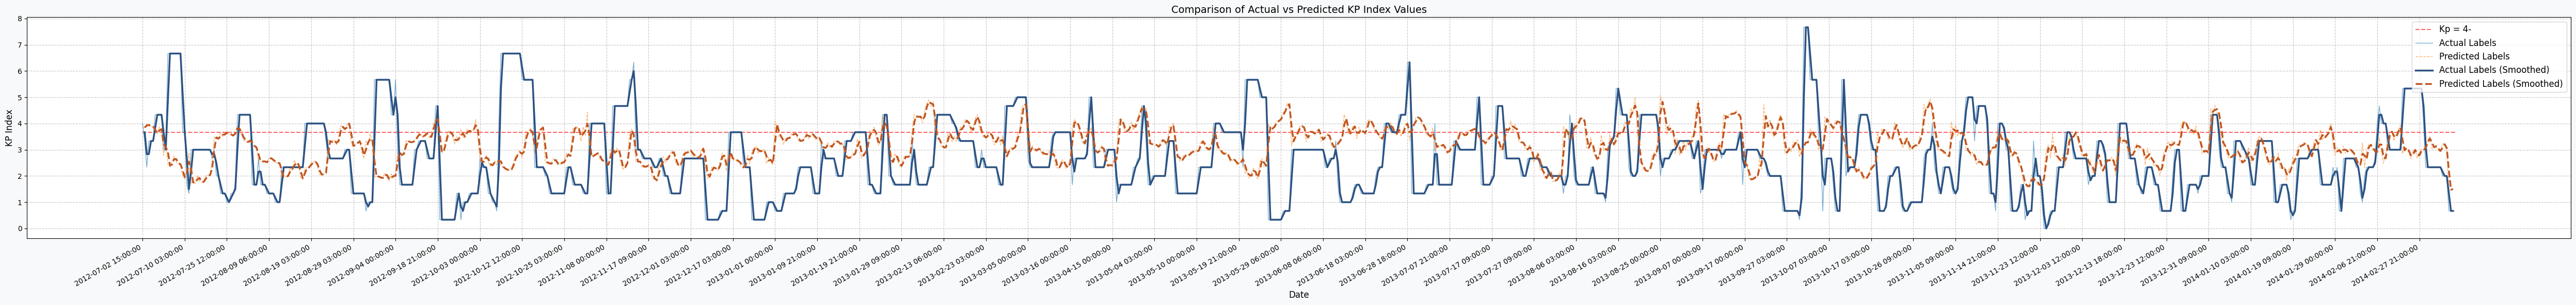

[np.float32(3.828125), np.float32(3.859375), np.float32(3.984375), np.float32(3.90625), np.float32(3.90625), np.float32(3.859375), np.float32(3.671875), np.float32(3.609375), np.float32(3.875), np.float32(3.6875), np.float32(2.78125), np.float32(3.421875), np.float32(2.453125), np.float32(2.34375), np.float32(2.53125), np.float32(2.765625), np.float32(2.515625), np.float32(2.46875), np.float32(2.421875), np.float32(2.015625), np.float32(1.8984375), np.float32(2.234375), np.float32(2.859375), np.float32(1.71875), np.float32(1.7890625), np.float32(1.7109375), np.float32(2.03125), np.float32(1.8203125), np.float32(1.7578125), np.float32(1.7890625), np.float32(2.0), np.float32(2.015625), np.float32(2.046875), np.float32(2.515625), np.float32(3.484375), np.float32(3.453125), np.float32(3.390625), np.float32(3.640625), np.float32(3.5), np.float32(3.65625), np.float32(3.640625), np.float32(3.609375), np.float32(3.5625), np.float32(3.515625), np.float32(3.71875), np.float32(3.90625), np.float3

Testing Progress:   0%|          | 0/128 [00:00<?, ?it/s]

Average test loss: 4.1322
RMSE: 2.0328
MSE: 4.1322
MAE: 1.6677
R²: -3.8917
R: -0.0988
True Skill Score: 0.0000
Accuracy: 0.1641
Precision: 1.0000
Recall: 0.1641
F1 Score: 0.2819


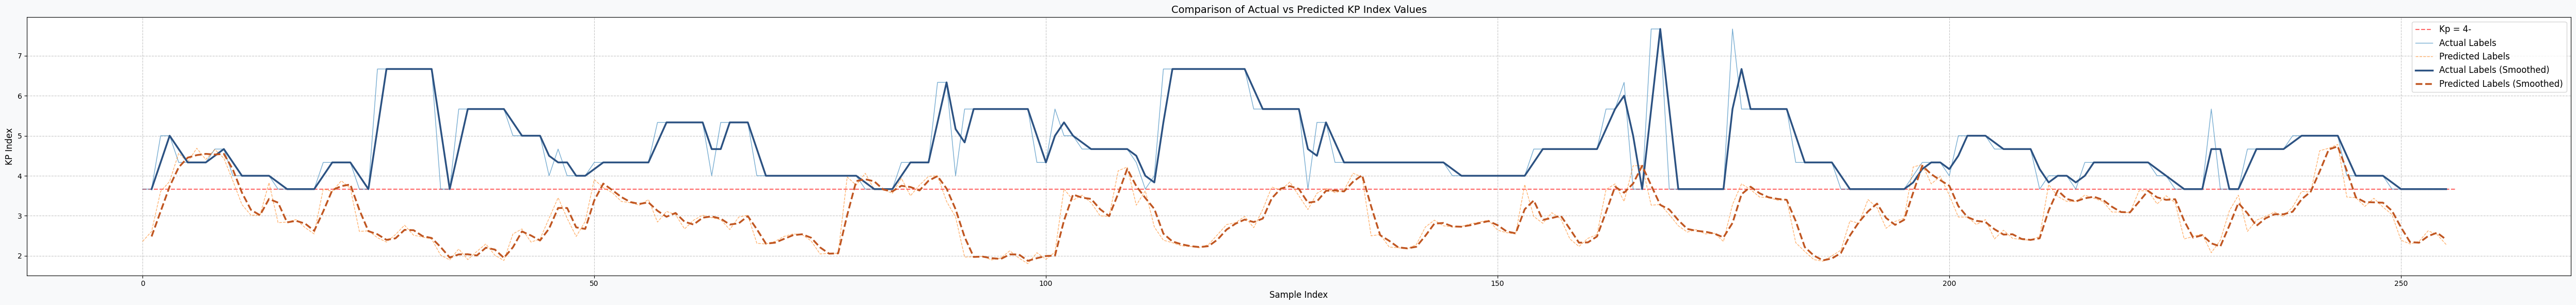

[np.float32(2.359375), np.float32(2.609375), np.float32(3.609375), np.float32(3.859375), np.float32(4.5625), np.float32(4.34375), np.float32(4.6875), np.float32(4.40625), np.float32(4.65625), np.float32(4.4375), np.float32(3.875), np.float32(3.28125), np.float32(3.015625), np.float32(3.015625), np.float32(3.828125), np.float32(2.828125), np.float32(2.84375), np.float32(2.90625), np.float32(2.703125), np.float32(2.546875), np.float32(3.671875), np.float32(3.609375), np.float32(3.875), np.float32(3.6875), np.float32(2.609375), np.float32(2.625), np.float32(2.453125), np.float32(2.34375), np.float32(2.53125), np.float32(2.765625), np.float32(2.515625), np.float32(2.46875), np.float32(2.421875), np.float32(2.015625), np.float32(1.8984375), np.float32(2.171875), np.float32(1.90625), np.float32(2.109375), np.float32(2.296875), np.float32(2.015625), np.float32(1.8828125), np.float32(2.546875), np.float32(2.671875), np.float32(2.34375), np.float32(2.421875), np.float32(2.9375), np.float32(3.45

Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.2614267109109383


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.2140924433950167


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.8237684419443874


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.0412720025859294


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.5995059088165267


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.234643192394049


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.3009814766056518


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.755419351324335


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.9987327030255934


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.4391703693297324


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.7602437392846285


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.5830264429101435


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.5940188483126777


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.4265329487481195


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.502340281438054


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.4980894347385956


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.41113815735578824


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.465611702580181


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.33787005567625983


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.274874194732567


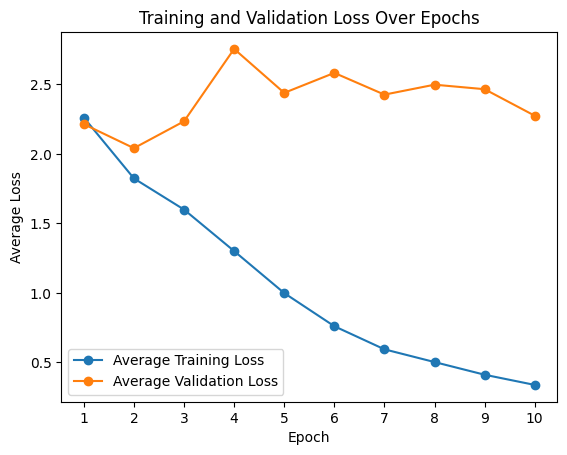

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 2.2749
RMSE: 1.5083
MSE: 2.2769
MAE: 1.1942
R²: -0.1293
R: 0.1928
True Skill Score: 0.3370
Accuracy: 0.6454
Precision: 0.4764
Recall: 0.2395
F1 Score: 0.3187


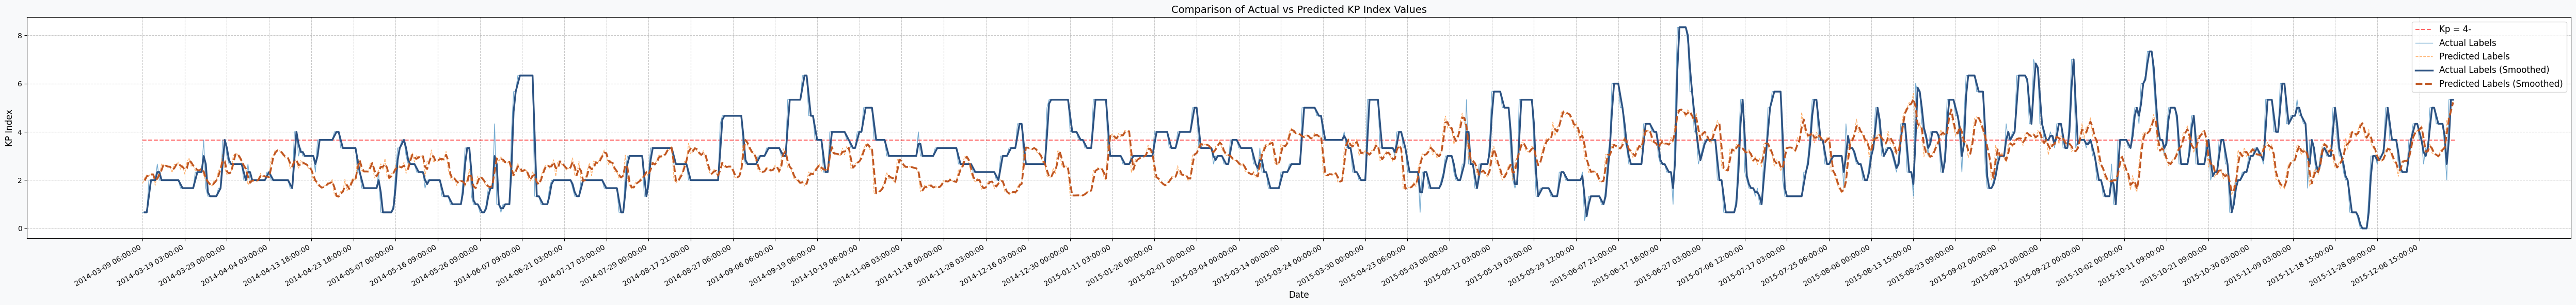

[np.float32(1.8671875), np.float32(2.09375), np.float32(2.21875), np.float32(2.171875), np.float32(2.28125), np.float32(2.203125), np.float32(1.7890625), np.float32(2.328125), np.float32(2.140625), np.float32(2.6875), np.float32(2.625), np.float32(2.578125), np.float32(2.546875), np.float32(2.5625), np.float32(2.3125), np.float32(2.65625), np.float32(2.625), np.float32(2.75), np.float32(2.453125), np.float32(2.640625), np.float32(2.25), np.float32(2.71875), np.float32(2.921875), np.float32(2.578125), np.float32(2.640625), np.float32(2.390625), np.float32(2.4375), np.float32(2.375), np.float32(2.5625), np.float32(2.15625), np.float32(2.0), np.float32(1.8671875), np.float32(1.796875), np.float32(1.7578125), np.float32(2.0), np.float32(1.96875), np.float32(2.390625), np.float32(2.53125), np.float32(3.09375), np.float32(2.484375), np.float32(2.234375), np.float32(2.3125), np.float32(2.34375), np.float32(3.0), np.float32(3.109375), np.float32(3.078125), np.float32(2.859375), np.float32(2.76

Testing Progress:   0%|          | 0/190 [00:00<?, ?it/s]

Average test loss: 4.0065
RMSE: 2.0016
MSE: 4.0065
MAE: 1.7121
R²: -3.0444
R: 0.3005
True Skill Score: 0.0000
Accuracy: 0.2395
Precision: 1.0000
Recall: 0.2395
F1 Score: 0.3864


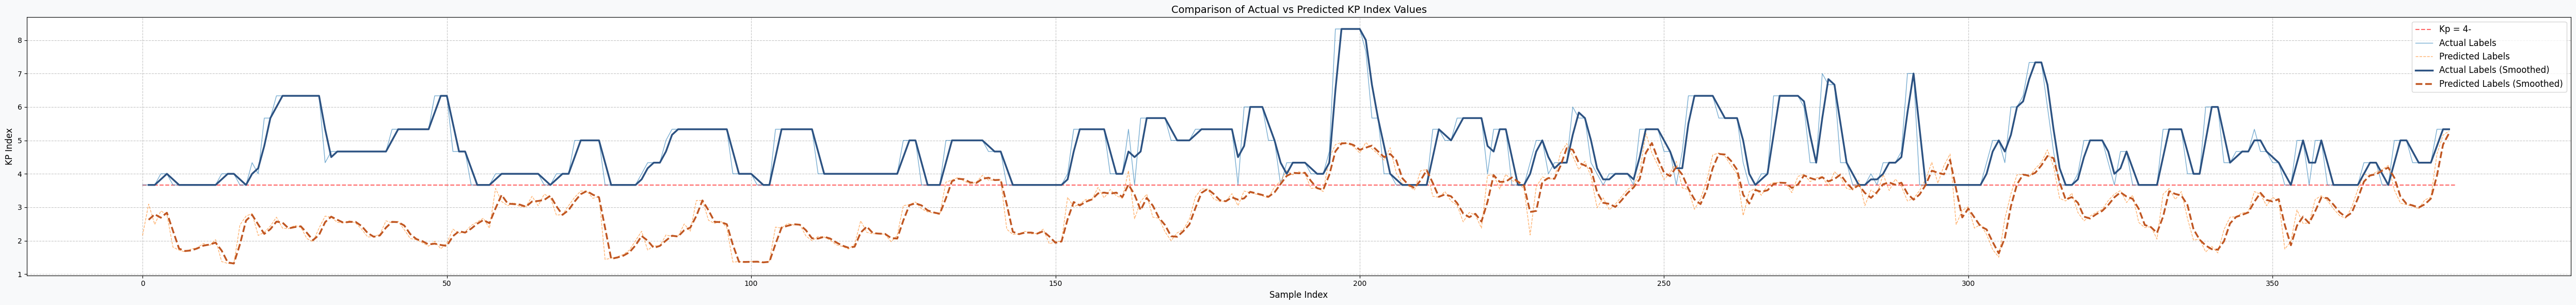

[np.float32(2.15625), np.float32(3.09375), np.float32(2.484375), np.float32(2.890625), np.float32(2.78125), np.float32(1.8046875), np.float32(1.71875), np.float32(1.6640625), np.float32(1.75), np.float32(1.7890625), np.float32(1.9140625), np.float32(1.8515625), np.float32(2.03125), np.float32(1.375), np.float32(1.3203125), np.float32(1.3125), np.float32(2.46875), np.float32(2.734375), np.float32(2.8125), np.float32(2.15625), np.float32(2.25), np.float32(2.4375), np.float32(2.703125), np.float32(2.375), np.float32(2.359375), np.float32(2.453125), np.float32(2.40625), np.float32(2.0625), np.float32(1.96875), np.float32(2.375), np.float32(2.734375), np.float32(2.703125), np.float32(2.546875), np.float32(2.53125), np.float32(2.59375), np.float32(2.53125), np.float32(2.34375), np.float32(2.109375), np.float32(2.125), np.float32(2.1875), np.float32(2.59375), np.float32(2.53125), np.float32(2.578125), np.float32(2.328125), np.float32(2.0625), np.float32(2.03125), np.float32(1.9375), np.float3

Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.363567194087176


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.875060682137601


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.8686014890948688


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.0075125474646476


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.592645968153361


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7179145264573512


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.1783192764536095


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8489284754028028


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.8591397727211032


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8104281317543869


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.6795447136786511


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.807729019573508


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.5388402186026123


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8471199247549468


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.457351242465639


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7768904296097088


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.391893370521275


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.922960830084557


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.3557184970018976


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.0146917431507783


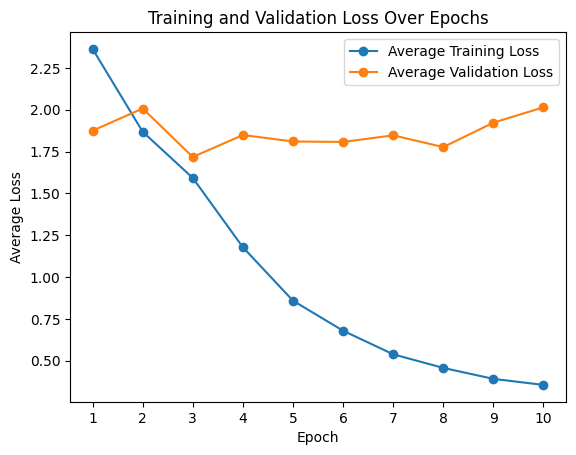

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 2.0147
RMSE: 1.4194
MSE: 2.0138
MAE: 1.1462
R²: -0.1491
R: 0.2333
True Skill Score: 0.3447
Accuracy: 0.6436
Precision: 0.5718
Recall: 0.4512
F1 Score: 0.5044


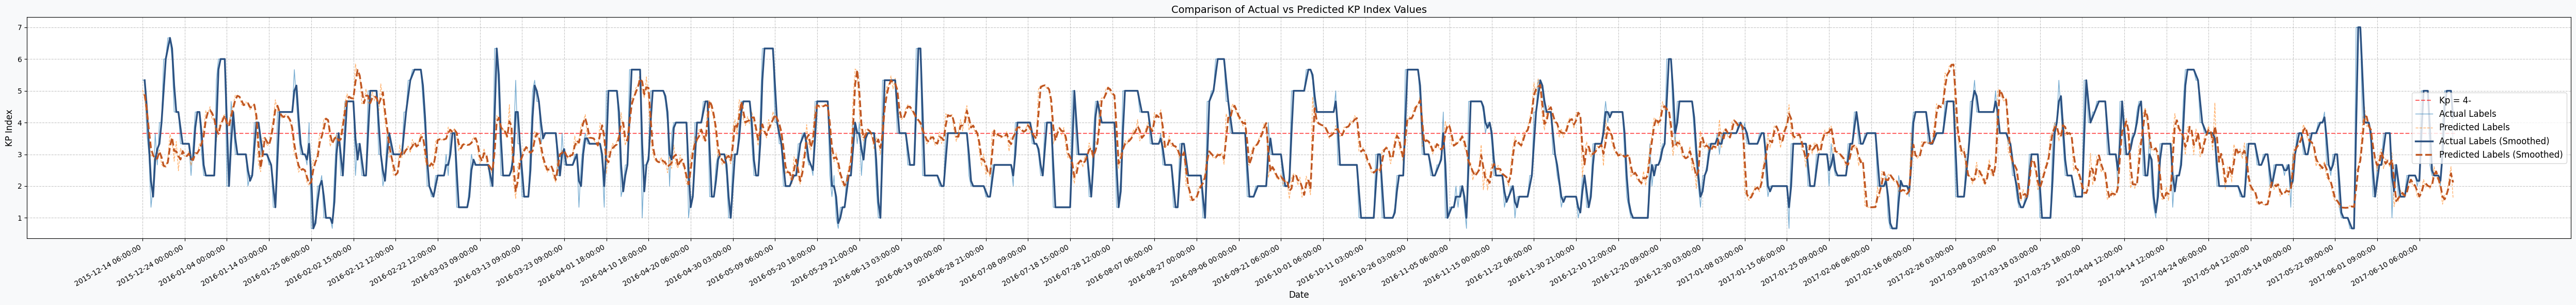

[np.float32(5.03125), np.float32(4.75), np.float32(4.09375), np.float32(3.453125), np.float32(2.921875), np.float32(3.015625), np.float32(2.703125), np.float32(3.03125), np.float32(3.140625), np.float32(2.6875), np.float32(2.59375), np.float32(2.640625), np.float32(2.859375), np.float32(3.625), np.float32(3.4375), np.float32(2.78125), np.float32(3.40625), np.float32(2.484375), np.float32(3.1875), np.float32(3.015625), np.float32(2.9375), np.float32(2.953125), np.float32(3.09375), np.float32(2.65625), np.float32(2.984375), np.float32(3.078125), np.float32(3.0), np.float32(3.328125), np.float32(3.34375), np.float32(3.796875), np.float32(4.375), np.float32(4.28125), np.float32(4.5), np.float32(4.09375), np.float32(4.15625), np.float32(3.40625), np.float32(3.875), np.float32(3.953125), np.float32(4.1875), np.float32(4.25), np.float32(3.734375), np.float32(4.03125), np.float32(4.34375), np.float32(4.5625), np.float32(4.875), np.float32(4.8125), np.float32(4.8125), np.float32(4.5625), np.flo

Testing Progress:   0%|          | 0/221 [00:00<?, ?it/s]

Average test loss: 2.4021
RMSE: 1.5499
MSE: 2.4054
MAE: 1.2322
R²: -3.1100
R: 0.0436
True Skill Score: 0.0000
Accuracy: 0.4512
Precision: 1.0000
Recall: 0.4512
F1 Score: 0.6219


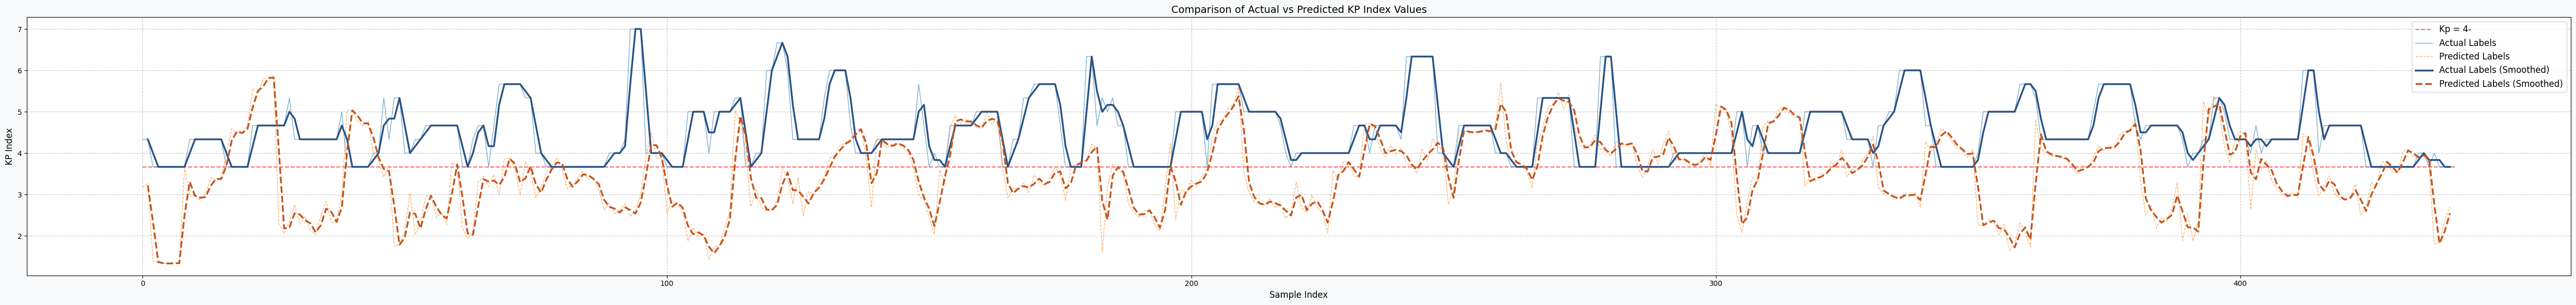

[np.float32(3.171875), np.float32(3.265625), np.float32(1.390625), np.float32(1.34375), np.float32(1.3359375), np.float32(1.328125), np.float32(1.34375), np.float32(1.3359375), np.float32(3.65625), np.float32(2.953125), np.float32(2.984375), np.float32(2.859375), np.float32(3.015625), np.float32(3.40625), np.float32(3.34375), np.float32(3.40625), np.float32(4.0), np.float32(4.59375), np.float32(4.46875), np.float32(4.5), np.float32(4.65625), np.float32(5.5625), np.float32(5.4375), np.float32(5.78125), np.float32(5.84375), np.float32(5.8125), np.float32(2.296875), np.float32(2.0625), np.float32(2.34375), np.float32(2.75), np.float32(2.28125), np.float32(2.46875), np.float32(2.140625), np.float32(2.03125), np.float32(2.484375), np.float32(2.828125), np.float32(2.328125), np.float32(2.34375), np.float32(3.03125), np.float32(5.03125), np.float32(5.03125), np.float32(4.78125), np.float32(4.65625), np.float32(4.78125), np.float32(3.984375), np.float32(3.8125), np.float32(3.421875), np.float3

Training Progress: Epoch: 1:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  2.392969288100228


Validation Progress: Epoch: 1:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.758714660531947


Training Progress: Epoch: 2:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  1.9046030972774184


Validation Progress: Epoch: 2:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.6195435555269995


Training Progress: Epoch: 3:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  1.5752312735600134


Validation Progress: Epoch: 3:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  2.157320811508477


Training Progress: Epoch: 4:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  1.1337276299267682


Validation Progress: Epoch: 4:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.930886571991088


Training Progress: Epoch: 5:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.873678029779052


Validation Progress: Epoch: 5:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.9946109878269702


Training Progress: Epoch: 6:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.678675158042397


Validation Progress: Epoch: 6:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  2.007501346258108


Training Progress: Epoch: 7:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.5597248585365218


Validation Progress: Epoch: 7:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  2.288210209631573


Training Progress: Epoch: 8:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.47039355474039013


Validation Progress: Epoch: 8:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  2.074350381862393


Training Progress: Epoch: 9:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.41227115261713854


Validation Progress: Epoch: 9:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  2.229937144783008


Training Progress: Epoch: 10:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.3584494599298761


Validation Progress: Epoch: 10:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  2.2423244642525573


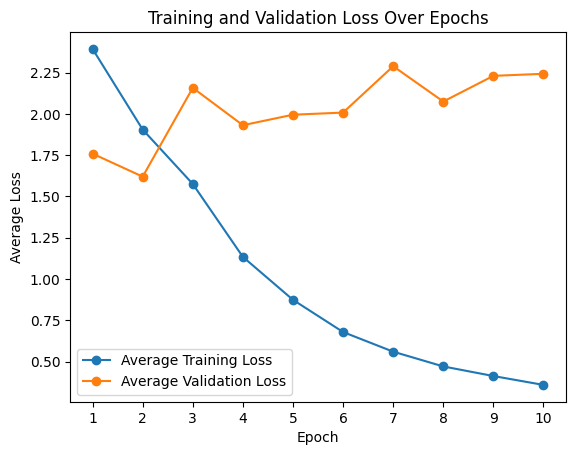

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/550 [00:00<?, ?it/s]

Average test loss: 2.2423
RMSE: 1.4974
MSE: 2.2388
MAE: 1.2266
R²: -0.3216
R: 0.1316
True Skill Score: 0.0816
Accuracy: 0.6315
Precision: 0.3322
Recall: 0.3246
F1 Score: 0.3284


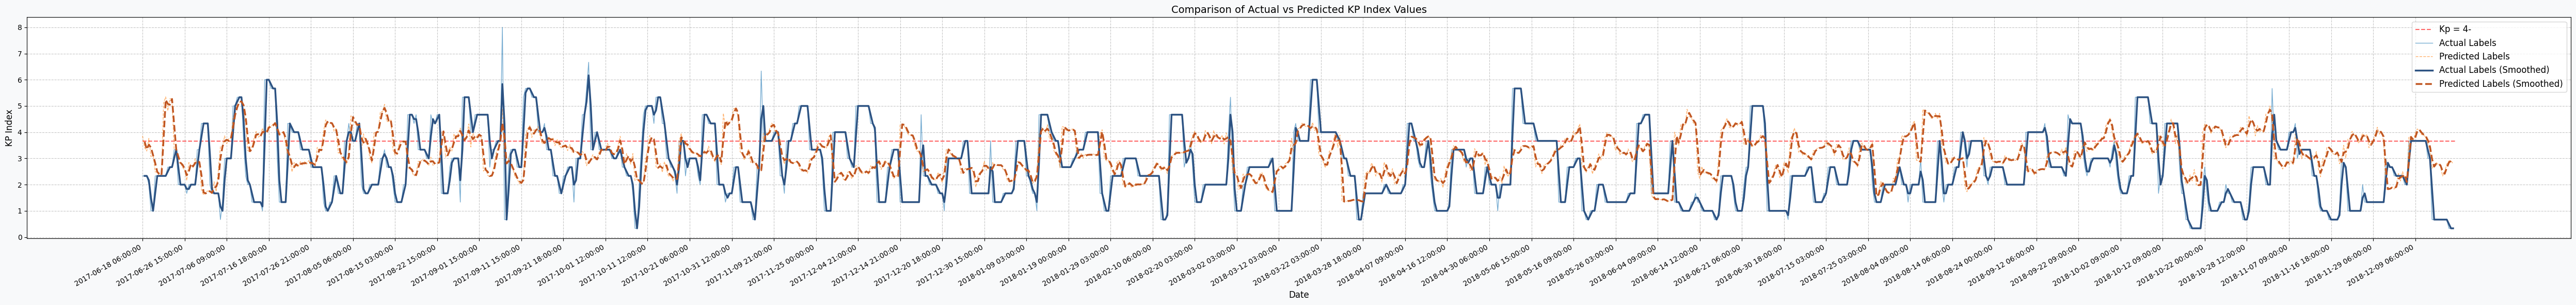

[np.float32(3.859375), np.float32(3.40625), np.float32(3.28125), np.float32(3.765625), np.float32(3.0625), np.float32(3.171875), np.float32(2.484375), np.float32(2.484375), np.float32(2.328125), np.float32(2.390625), np.float32(5.125), np.float32(5.34375), np.float32(4.8125), np.float32(5.28125), np.float32(5.25), np.float32(3.359375), np.float32(3.328125), np.float32(2.8125), np.float32(2.859375), np.float32(2.65625), np.float32(2.5625), np.float32(2.15625), np.float32(2.84375), np.float32(2.734375), np.float32(2.65625), np.float32(2.984375), np.float32(2.8125), np.float32(2.90625), np.float32(1.8046875), np.float32(1.6015625), np.float32(1.7265625), np.float32(1.7578125), np.float32(1.734375), np.float32(1.640625), np.float32(2.109375), np.float32(1.734375), np.float32(2.546875), np.float32(3.453125), np.float32(3.453125), np.float32(3.859375), np.float32(3.5625), np.float32(3.765625), np.float32(3.765625), np.float32(4.59375), np.float32(4.71875), np.float32(5.1875), np.float32(5.12

Testing Progress:   0%|          | 0/153 [00:00<?, ?it/s]

Average test loss: 1.9364
RMSE: 1.3915
MSE: 1.9392
MAE: 1.1852
R²: -3.0598
R: 0.2165
True Skill Score: 0.0000
Accuracy: 0.3246
Precision: 1.0000
Recall: 0.3246
F1 Score: 0.4901


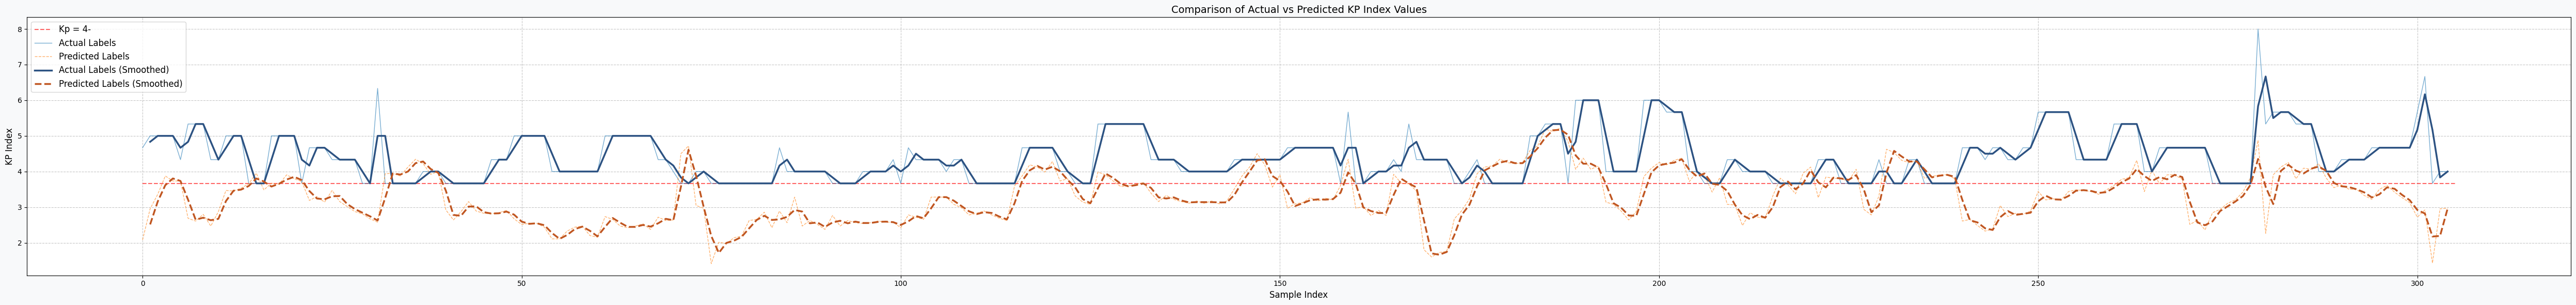

[np.float32(2.078125), np.float32(2.953125), np.float32(3.359375), np.float32(3.875), np.float32(3.734375), np.float32(3.734375), np.float32(2.6875), np.float32(2.609375), np.float32(2.796875), np.float32(2.46875), np.float32(2.875), np.float32(3.46875), np.float32(3.453125), np.float32(3.53125), np.float32(3.65625), np.float32(3.953125), np.float32(3.484375), np.float32(3.671875), np.float32(3.640625), np.float32(3.90625), np.float32(3.796875), np.float32(3.71875), np.float32(3.1875), np.float32(3.296875), np.float32(3.140625), np.float32(3.46875), np.float32(3.15625), np.float32(3.015625), np.float32(2.875), np.float32(2.8125), np.float32(2.671875), np.float32(2.578125), np.float32(3.9375), np.float32(3.953125), np.float32(3.875), np.float32(4.125), np.float32(4.34375), np.float32(4.21875), np.float32(3.921875), np.float32(4.0), np.float32(2.921875), np.float32(2.640625), np.float32(2.875), np.float32(3.15625), np.float32(2.890625), np.float32(2.828125), np.float32(2.8125), np.float3

In [ ]:
torch.set_float32_matmul_precision('medium')
fabric = Fabric(accelerator='cuda', devices=1, precision="bf16-mixed")
fabric.launch(train_model)


In [ ]:
# prompt: disconnect runtime
import time
time.sleep(5 * 60)
from google.colab import runtime
runtime.unassign()
